<a href="https://colab.research.google.com/github/khirodsahoo93/Whatsapp-analyser/blob/master/WhatsApp_analyser_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
#Import all the essential libraries
import numpy as np
import seaborn as sns
import pandas as pd
!pip install -q emoji
import warnings
warnings.filterwarnings("ignore")
import nltk
import re
import datetime
import string
import emoji
sns.set(style='darkgrid')
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from os import path
from PIL import Image
nltk.download('punkt')
nltk.download('vader_lexicon')
from IPython.display import set_matplotlib_formats

Female_names=['Shree Parida','Subhasmita Swain','Saismita Mohapatra','Pupul','Samiksha Pradhan Burla','Manisha','Aanchal']
Group=[]
Group=pd.DataFrame(Group)
FilePath='/content/WhatsApp Chat with Pupul.txt'
explode=[0.1,0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 51kB 2.5MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
#@title
#Extract raw whatsapp data and convert it into Panda DataFrame
#Let's begin our journrey. Good Luck!!

#Function to check if the text is a new one or a continuation of old one.
def DateStart(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]|[0-9]):([0-9][0-9])'
    result = re.match(pattern, s)
    if result:
        return True
    return False

#Function to check if there is any author of the text
def AuthorStart(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

#Function to fetch details a single line of text: date,time,author,message
def getDetails(line):
    splitLine = line.split(' - ')  
    dateTime = splitLine[0]
    date, time = dateTime.split(', ')  
    message = ' '.join(splitLine[1:])  
    if AuthorStart(message):  
        splitMessage = message.split(': ')  
        author = splitMessage[0]  
        message = ' '.join(splitMessage[1:])  
    else:
        author = None
    return date, time, author, message


parsedData = []  # List to keep track of data so it can be used by a Pandas dataframe
ChatPath = FilePath
with open(ChatPath, encoding="utf-8") as fp:
    fp.readline()  # Skipping first line of the file (usually contains information about end-to-end encryption)

    messageBuffer = []  # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None  # Intermediate variables to keep track of the current message being processed

    while True:
        line = fp.readline()
        #print(line)# can read lines
        if not line:  # Stop reading further if end of file has been reached
            break
        line = line.strip()  # Guarding against erroneous leading and trailing whitespaces
        #print(line)#print lines properly
        if DateStart(line):  # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0:  # Check if the message buffer contains characters from previous iterations
                #print(messageBuffer)
                parsedData.append([date, time, author,' '.join(messageBuffer)])
                #print(parsedData)# Save the tokens from the previous message in parsedData
            messageBuffer.clear()  # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDetails(line)  # Identify and extract tokens from the line
            messageBuffer.append(message)  # Append message to buffer

        else:
            #print('Entered else loop')#entering here
            messageBuffer.append(line)  # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer


df=pd.DataFrame(parsedData,columns=['Date','Time','Author','Message'])
#df.to_csv(r'/Users/khirod/PycharmProjects/new/whatsapp.csv', index = False, header=True)
iter=df.shape[0]
df['Gender']=''
def assign_gender(df):
    for i in range(df.shape[0]):
        if (df['Author'][i] in Female_names) :
            df['Gender'].iloc[i]='female'

        elif (df['Author'][i]== None):
            df['Gender'].iloc[i]='None'
        else:
            df['Gender'].iloc[i] = 'male'


assign_gender(df)
#print(df[['Author','Gender']].drop_duplicates(subset='Author'))#print unique rows
#print(df.describe())
#print(df[df['Author'].isnull()]['Message'])
media_messages_df = df[df['Message'] == '<Media omitted>']
#print(media_messages_df.head())

#create group dataframe for storing group information
temp_m=pd.DataFrame(df[df['Gender']=='male'])
temp_f=pd.DataFrame(df[df['Gender']=='female'])
temp2_m=pd.DataFrame(temp_m[['Author','Gender']].drop_duplicates(subset='Author'))
temp2_f=pd.DataFrame(temp_f[['Author','Gender']].drop_duplicates(subset='Author'))
Group=[]
Group=pd.DataFrame(Group)
Group['Males']=[len(temp2_m)]
Group['Females']=[len(temp2_f)]
Group.head()

,Males,Females
0,1,1


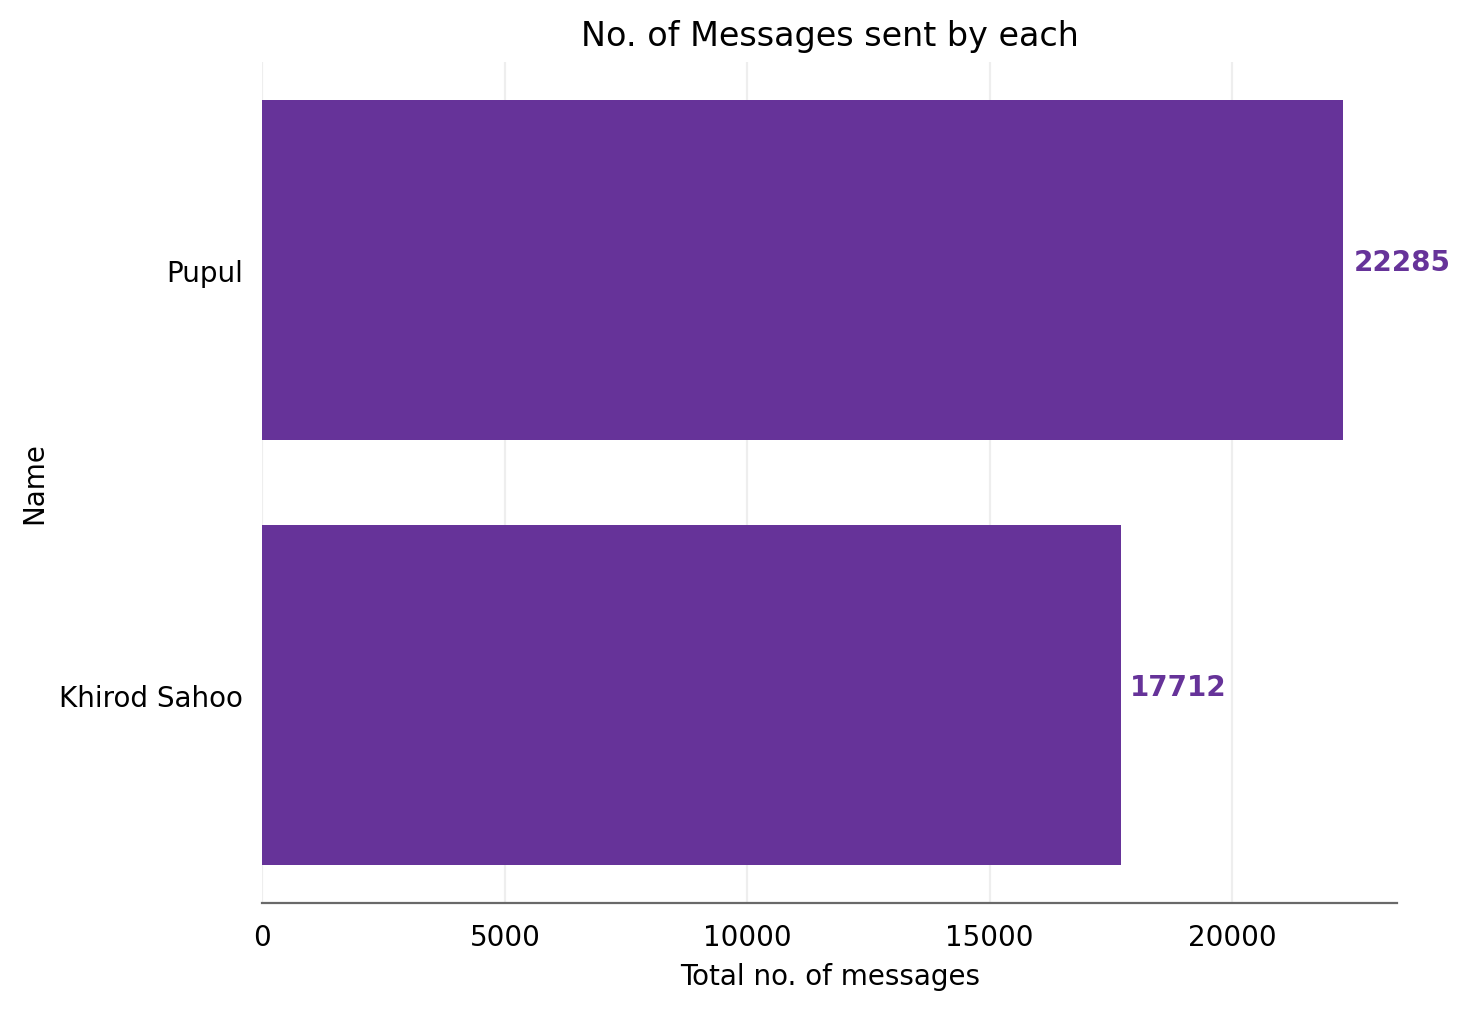

In [3]:
#@title

#Find the most talkative person in the group

author_talkative=df['Author'].value_counts().sort_values(ascending=True)#count no. of messages per author
author_talkative_df=pd.DataFrame({'Author':author_talkative.index,'Messages_texted':author_talkative})
Group['Messages_texted']=author_talkative.sum()
#print(Group)
#print(author_talkative.index)
def bar_plot(author_talkative,x_label,y_label,title): #create a bar plot to display results

  labels=np.array(author_talkative.index)
  y_pos=np.arange(len(author_talkative))
  plt.rcdefaults() #reset matplotdefault parameters
  set_matplotlib_formats('retina', quality=100)#increase the resolution of the plot

  fig,axes=plt.subplots() #use artist layer of matplotlib to create beautiful charts
  plt.rcParams['figure.figsize'] = (8, 5)
  fig.tight_layout()

  bars=axes.barh(y_pos,width=author_talkative,height=0.8,color='rebeccapurple')
  axes.set_yticks(y_pos)
  axes.set_yticklabels(labels)
  axes.set_xlabel(x_label)
  axes.set_ylabel(y_label)
  axes.set_title(title)
# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
  axes.spines['top'].set_visible(False)
  axes.spines['right'].set_visible(False)
  axes.spines['left'].set_visible(False)
  axes.spines['bottom'].set_color('dimgray')

# Second, remove the ticks as well.
  axes.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
  axes.set_axisbelow(True)#Set whether axis ticks and gridlines are above or below most artists.
  axes.yaxis.grid(False)
  axes.xaxis.grid(True, color='#EEEEEE')

# Grab the color of the bars so we can make the

  for i, v in enumerate(author_talkative):
    #print(str(i)+" "+str(v))
    axes.text(v + v/100, i , str(v), color=bars[0].get_facecolor(), fontweight='bold')

  plt.show()
bar_plot(author_talkative,'Total no. of messages','Name','No. of Messages sent by each')

In [0]:
#Pie chart
def pie(df,explode,title):

  labels = np.array(df.index)
  sizes = df.values
  # only "explode" the 2nd slice (i.e. 'Hogs')
  
  fig1, ax1 = plt.subplots()
  ax1.pie(sizes,explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
  # Equal aspect ratio ensures that pie is drawn as a circle
  ax1.axis('equal')  
  plt.tight_layout()
  ax1.set_title(title,pad=25)
  plt.show()


In [5]:
#@title
#Authors with no name
null_authors=df[df['Author'].isnull()]
print(null_authors['Message'])
Group['Activities']=len(null_authors)
print(Group)

Series([], Name: Message, dtype: object)
   Males  Females  Messages_texted  Activities
0      1        1            39997           0


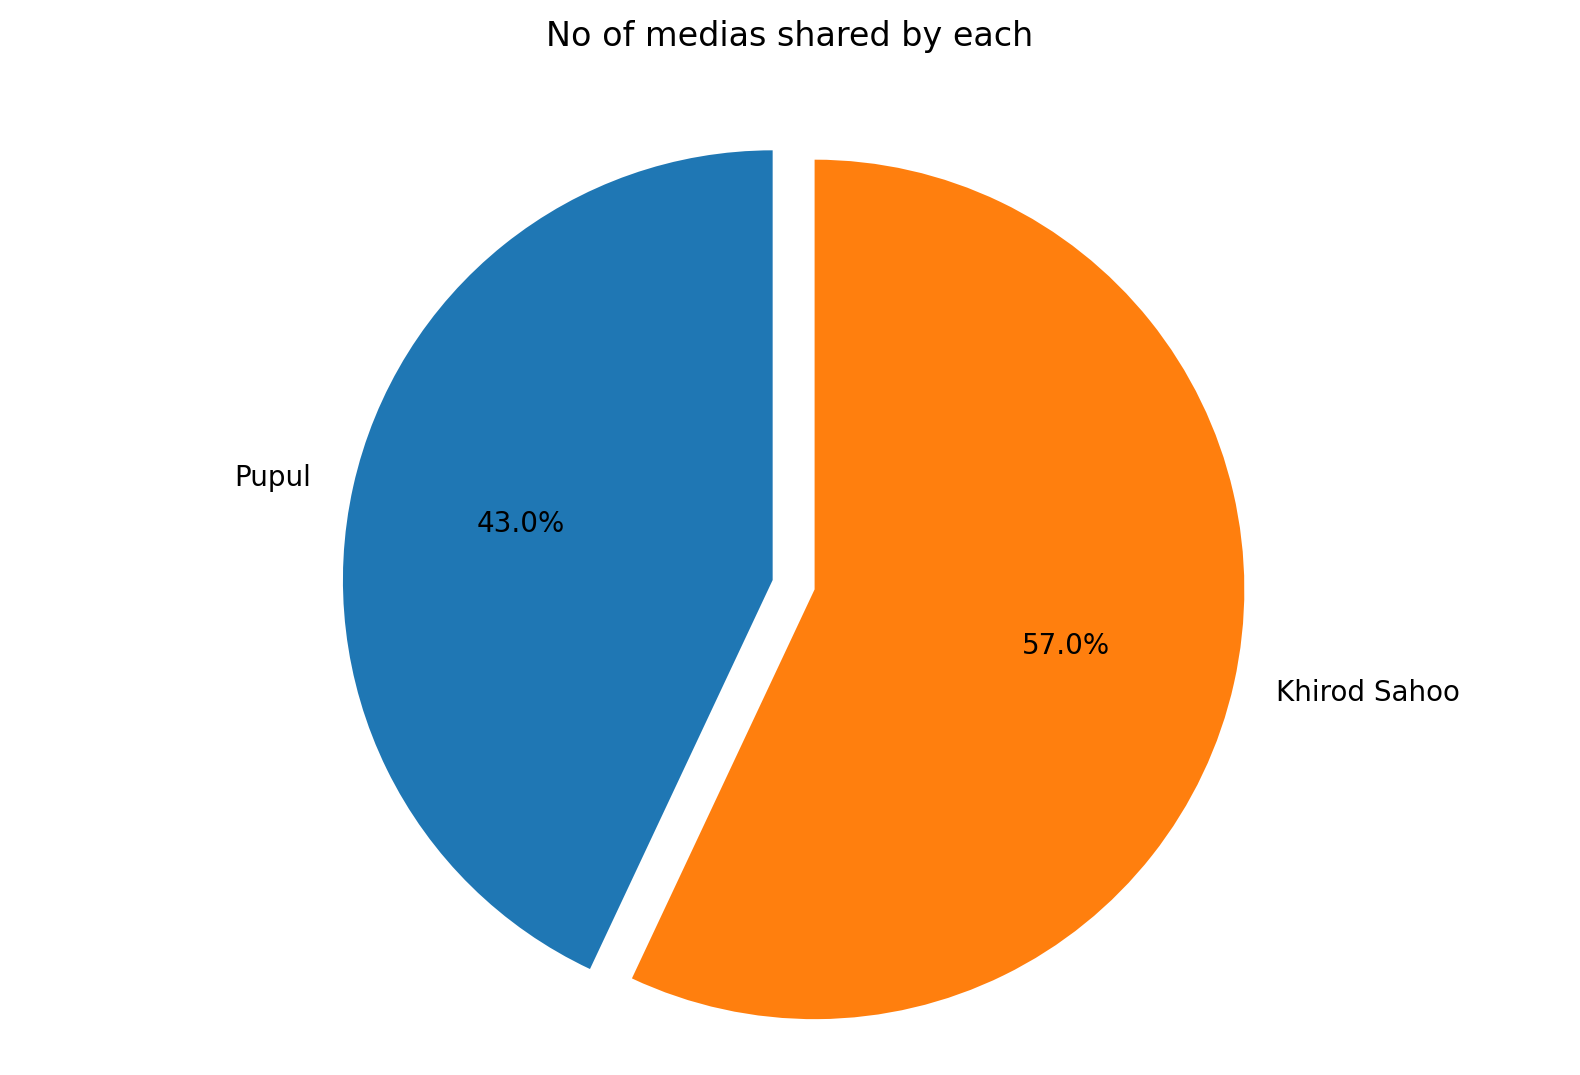

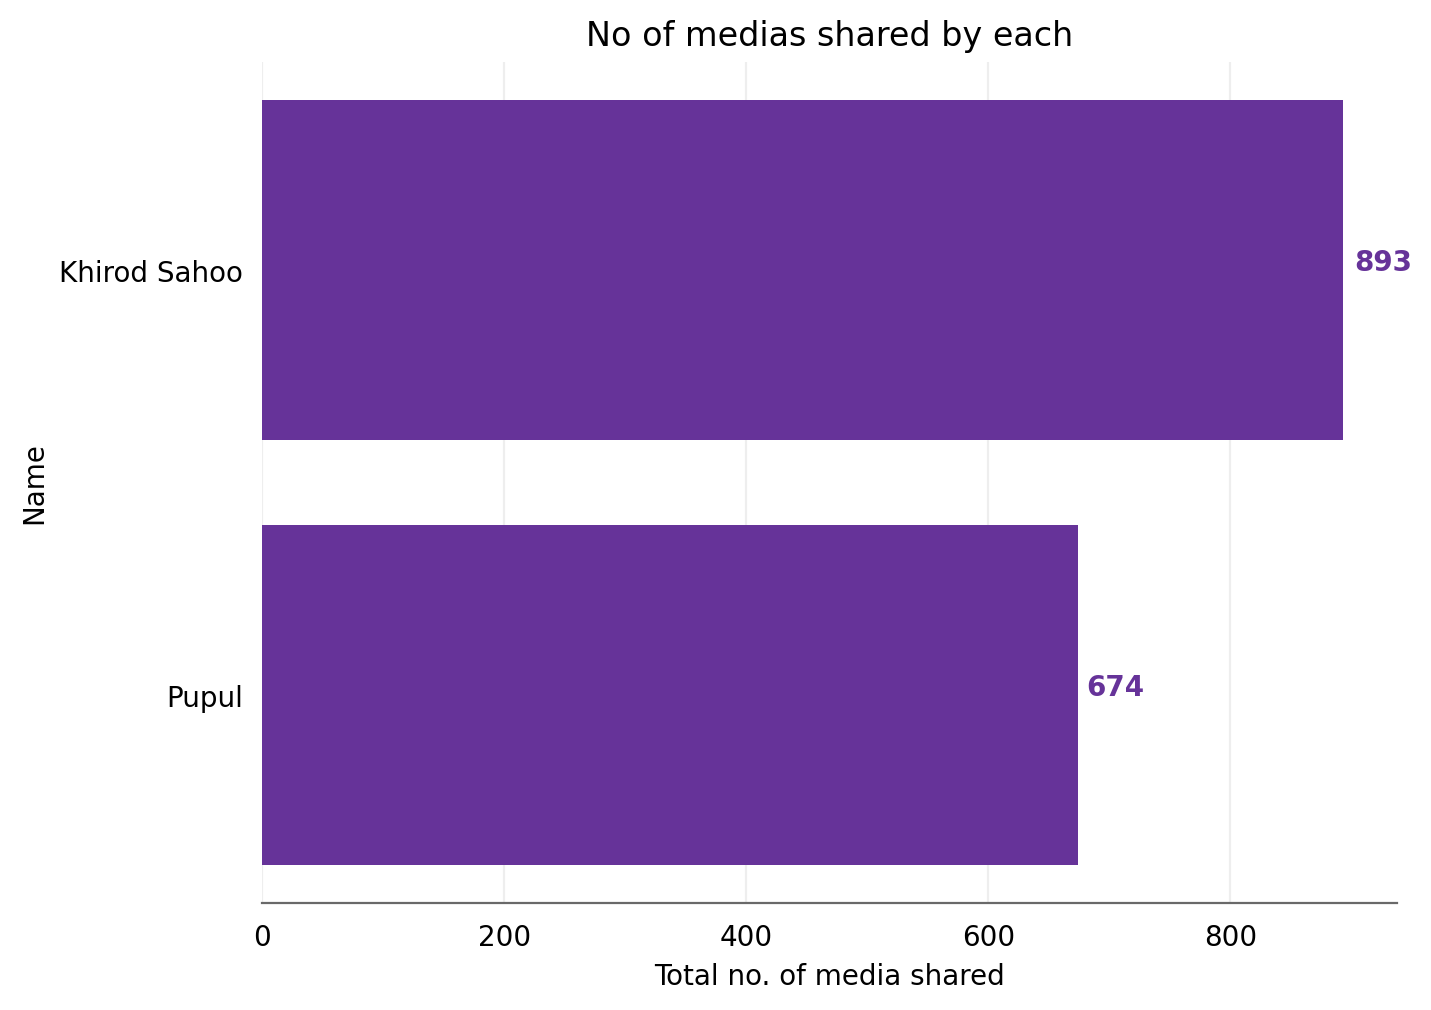

In [6]:
#@title
#Find no. of medias shared by each individual i.e spammer
media_messages = df[df['Message'] == '<Media omitted>']
#print(media_messages.head())
Group['Media_shared']=len(media_messages)
#print(Group)
author_media_messages_value_counts = media_messages['Author'].value_counts().sort_values(ascending=True)
author_media_messages_value_counts_df=pd.DataFrame({'Author':author_media_messages_value_counts.index,'Media_shared':author_media_messages_value_counts})
#print(author_media_messages_value_counts_df)

pie(author_media_messages_value_counts,explode,'No of medias shared by each')
bar_plot(author_media_messages_value_counts,'Total no. of media shared','Name','No of medias shared by each')

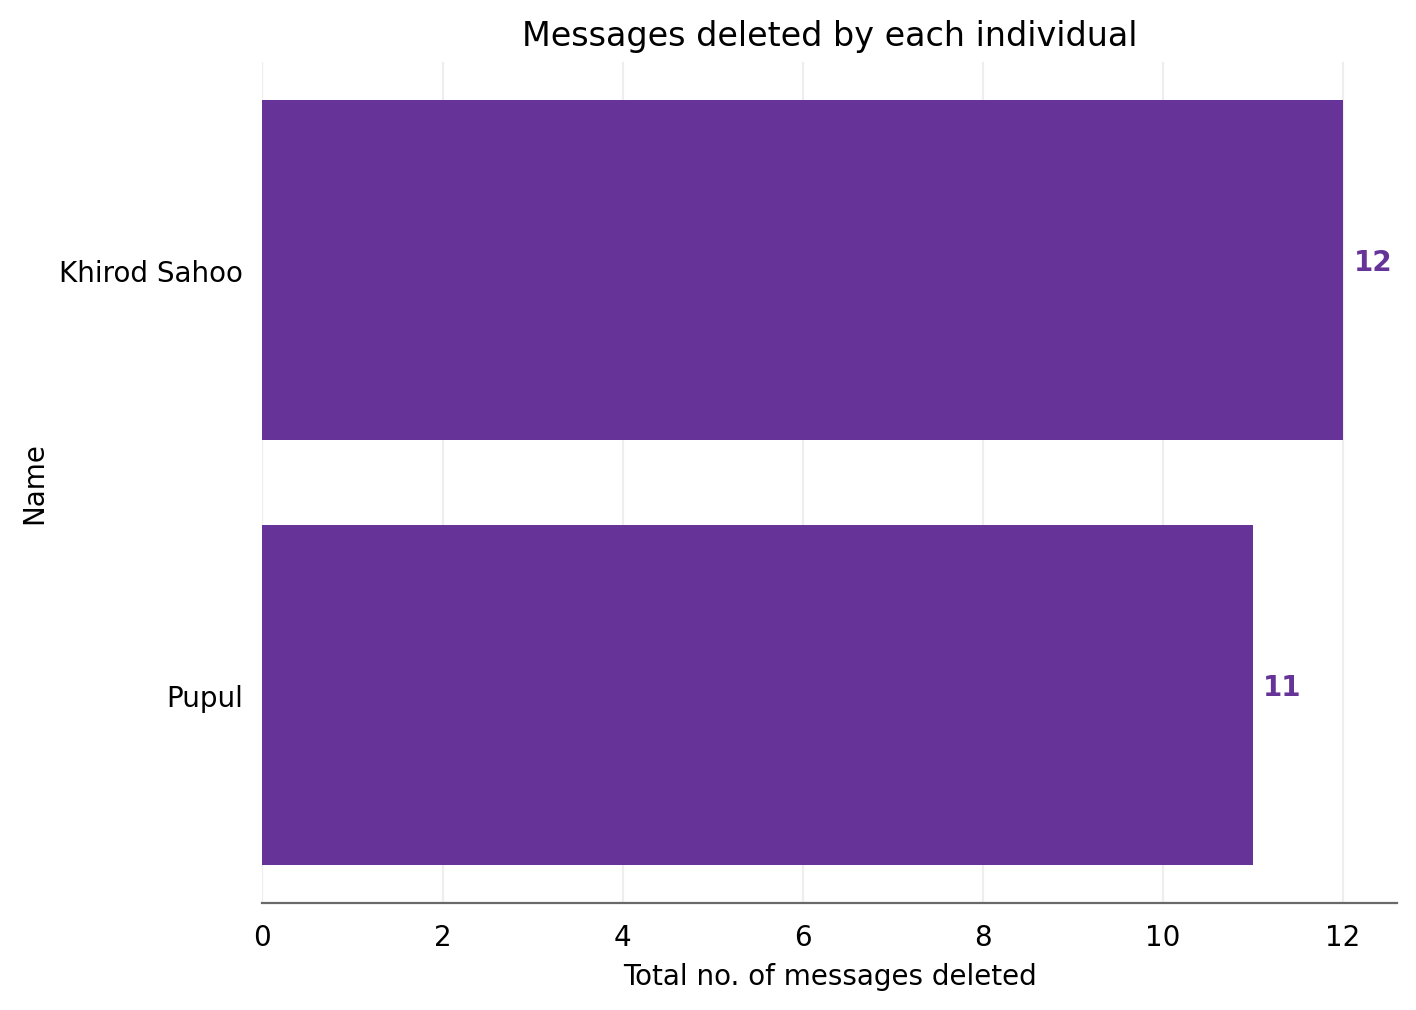

In [7]:
#@title
#Find the most controversial individual of the group

controversial_messages_df=df[df['Message']=='You deleted this message']
controversial_messages_df=controversial_messages_df.append(df[df['Message']=='This message was deleted'])
Group['Total_deleted_Msgs']=len(controversial_messages_df)
#print(Group)
#print(controversial_messages_df)
controversial_messages_counts=controversial_messages_df['Author'].value_counts().sort_values(ascending=True)
controversial_messages_count_df=pd.DataFrame({'Author':controversial_messages_counts.index,'Messages_Deleted':controversial_messages_counts})
#print(controversial_messages_count_df)
bar_plot(controversial_messages_counts,'Total no. of messages deleted','Name','Messages deleted by each individual')

In [8]:
#@title
#data cleaning
df.head()
#Authors with no name
null_authors=df[df['Author'].isnull()]
print(null_authors['Message'])

df_clean=df.drop(null_authors.index)# removing authors with no name or null authors
df_clean['Date']=pd.to_datetime(df_clean['Date'],dayfirst=True)# converting date from string to date format
df_clean.head()

#Insert hours of the day in 24hrs format
def convert24(str1): 
      
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if (str1[-2:]).lower() == "am" and (str1[:2]).lower() == "12": 
        return str(0) 
          
    # remove the AM     
    elif (str1[-2:]).lower() == "am": 
        return str1[:2].replace(':','') 
      
    # Checking if last two elements of time 
    # is PM and first two elements are 12    
    elif (str1[-2:]).lower() == "pm" and (str1[:2]).lower() == "12": 
        return str1[:2].replace(':','')  
          
    else: 
          
        # add 12 to hours and remove PM 
        return str(int(str1[:2].replace(':','')) + 12) 
          
print(convert24("12:40   pm")) 
df_clean['Hours']=df_clean['Time'].apply(lambda x : convert24(x.strip()))
df_clean.head() 

Series([], Name: Message, dtype: object)
12


,Date,Time,Author,Message,Gender,Hours
0,2019-01-11,7:32 pm,Pupul,Tate pasand nahi jadi kan jibi,female,19
1,2019-01-11,7:32 pm,Pupul,Se brown kambal ta choto heijae na tk,female,19
2,2019-01-11,7:33 pm,Khirod Sahoo,Oh mo pain anithantu🤭,male,19
3,2019-01-11,7:33 pm,Pupul,<Media omitted>,female,19
4,2019-01-11,7:33 pm,Pupul,This is a quilt,female,19


In [9]:
#@title
#Group by Authors total no. of letters & total no. of words
df_clean['Letter_count']=df['Message'].apply(lambda s:len(s))
df_clean['Word_count']=df['Message'].apply(lambda s:len(s.split(' ')))
df_clean.head()
Group['Letter_count']=df_clean['Letter_count'].sum()
Group['Word_count']=df_clean['Word_count'].sum()
print(Group)
#Table to show total no. of words and letters used by each individual
group_df=df_clean.groupby(['Author'])['Letter_count','Word_count'].sum().sort_values(by=['Word_count','Letter_count'],ascending=False)
print(pd.DataFrame(group_df))

   Males  Females  ...  Letter_count  Word_count
0      1        1  ...        682477      132000

[1 rows x 8 columns]
              Letter_count  Word_count
Author                                
Pupul               354894       71680
Khirod Sahoo        327583       60320


In [10]:
#@title
#Display the most common no. of words used in the chat
word_count_value_counts=df_clean['Word_count'].value_counts()
word_count_value_counts_df=pd.DataFrame(word_count_value_counts)
word_count_value_counts_df.columns=['Count']
word_count_value_counts_df.reset_index(inplace=True)
word_count_value_counts_df.columns=['Word Count','Count']
word_count_value_counts_df

,Word Count,Count
0,1,13574
1,2,7264
2,3,5239
3,4,4338
4,5,3243
...,...,...
56,106,1
57,74,1
58,104,1
59,136,1


([<matplotlib.axis.XTick at 0x7fa4f824cf28>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10')])

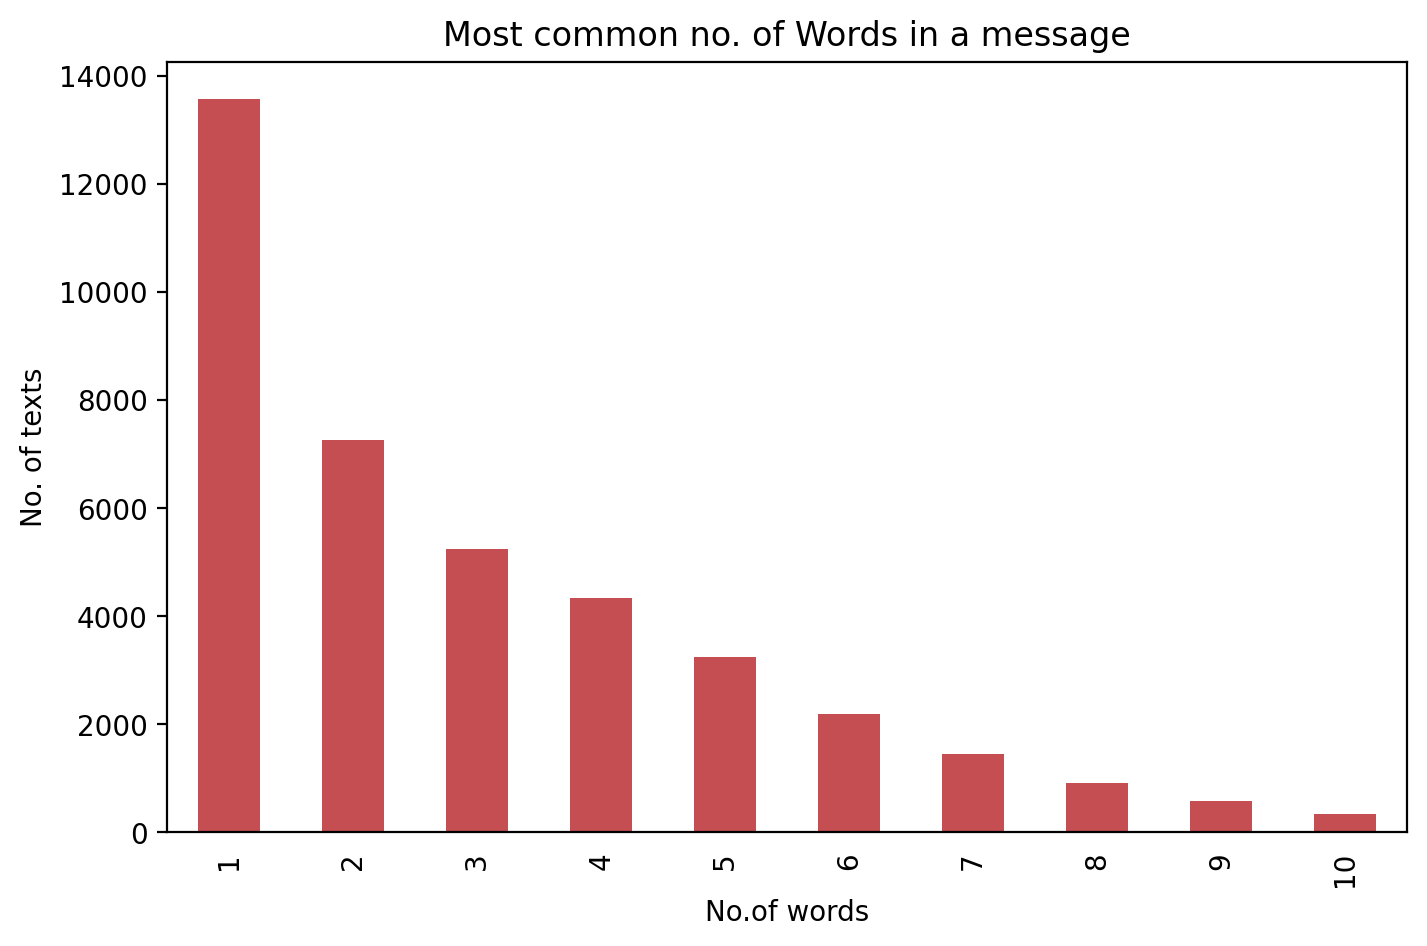

In [11]:
#@title
#Display the most common no. of words used in the chat
word_count_value_counts=df_clean['Word_count'].value_counts()
word_count_value_counts_df=pd.DataFrame(word_count_value_counts)
word_count_value_counts_df.columns=['Count']
word_count_value_counts_df.reset_index(inplace=True)
word_count_value_counts_df.columns=['Word_Count','Count']
sorted_df=word_count_value_counts_df.sort_values('Count',ascending=False).head(10)
sorted_df['Count'].plot.bar(color='r')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelsize=10,
    zorder=0,
    grid_alpha=0
    
) 
plt.title('Most common no. of Words in a message')
plt.xlabel('No.of words')
plt.ylabel('No. of texts')
plt.xticks(ticks=np.arange(10),labels=np.array(sorted_df['Word_Count']))


([<matplotlib.axis.XTick at 0x7fa4f81cdac8>,
 [Text(0, 0, '3'),
  Text(0, 0, '1'),
  Text(0, 0, '15'),
  Text(0, 0, '4'),
  Text(0, 0, '2'),
  Text(0, 0, '6'),
  Text(0, 0, '5'),
  Text(0, 0, '17'),
  Text(0, 0, '7'),
  Text(0, 0, '9')])

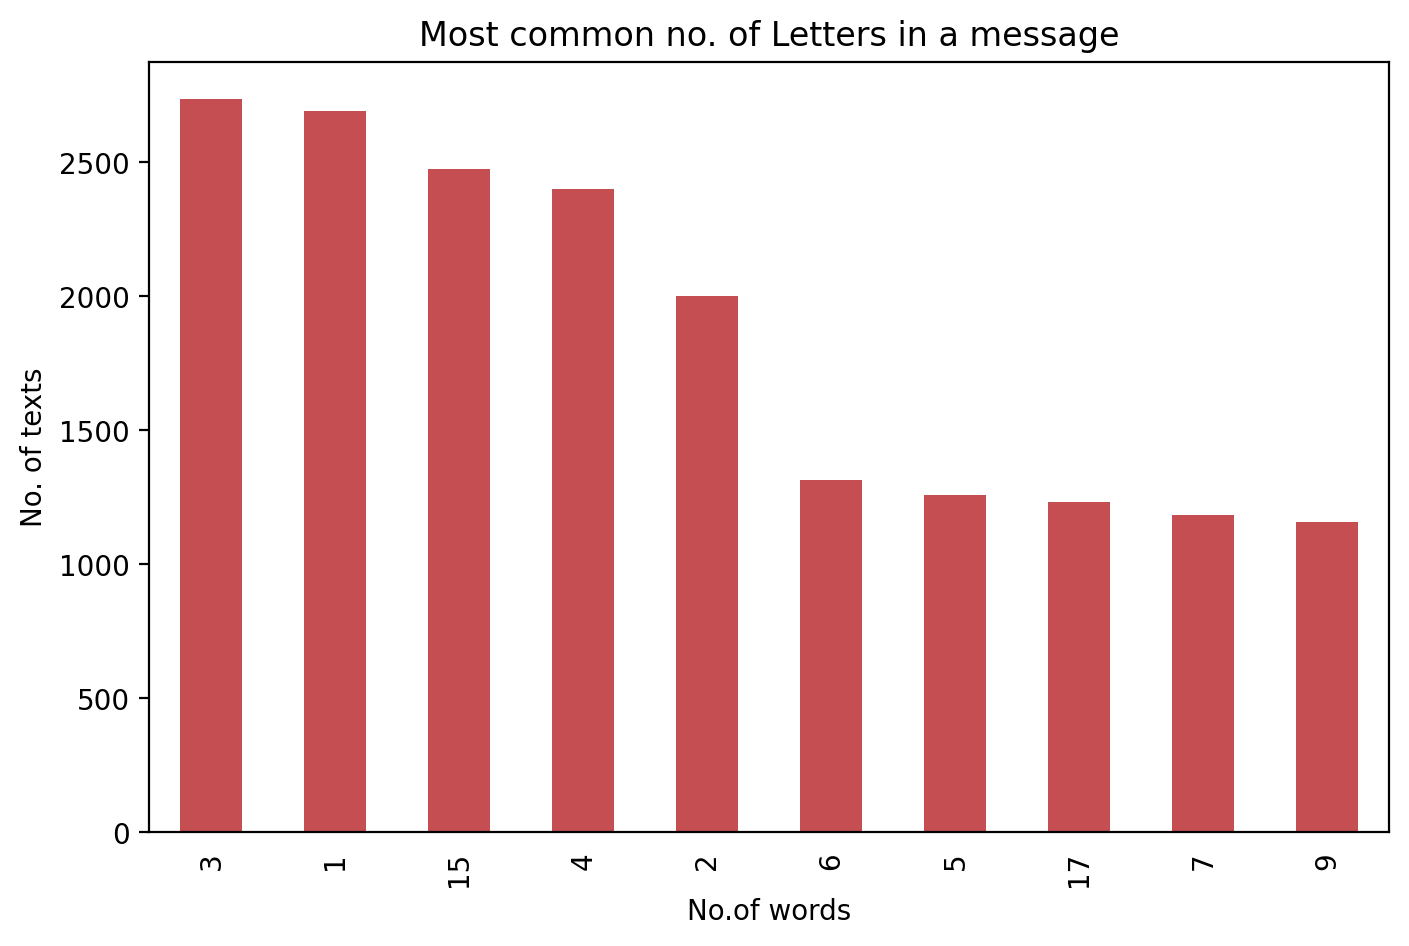

In [12]:
#@title
#Display the most common no. of letters used in the chat
letter_count_value_counts=df_clean['Letter_count'].value_counts().sort_index(ascending=True)
letter_count_value_counts_df=pd.DataFrame(letter_count_value_counts)
letter_count_value_counts_df.columns=['Count']
letter_count_value_counts_df.reset_index(inplace=True)
letter_count_value_counts_df.columns=['Letter_Count','Count']
sorted_df=letter_count_value_counts_df.sort_values('Count',ascending=False).head(10)
sorted_df['Count'].plot.bar(color='r')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelsize=10,
    zorder=0,
    grid_alpha=0
    
) 
plt.title('Most common no. of Letters in a message')
plt.xlabel('No.of words')
plt.ylabel('No. of texts')
plt.xticks(ticks=np.arange(10),labels=np.array(sorted_df['Letter_Count']))


In [13]:
#@title
#expand our dataset

author_min_date=pd.DataFrame(df_clean.groupby('Author')['Date'].min())#Find the first date of texting by the individual
author_max_date=pd.DataFrame(df_clean.groupby('Author')['Date'].max())#Find the last date of texting by the individual
author_info=author_min_date.merge(author_max_date,on='Author', how='left',indicator=True)
author_info.rename(columns={'Date_x':'Start_date','Date_y':'Last_date'},inplace=True)
print(author_info)

group_min_date=df_clean['Date'].min()#Find the first date of texting by the group
group_max_date=df_clean['Date'].max()#Find the last date of texting by the group
Group['Start_date']=[group_min_date]
Group['Last_date']=[group_max_date]
print(Group)
#-----------------------------------------Using Text to column approach of excel in python to get day month and year----------------#

#author_info['start_day']=''
#author_info['start_month']=''
#author_info['start_year']=''
#author_info['last_day']=''
#author_info['last_month']=''
#author_info['last_year']=''
#author_info[['start_day','start_month','start_year']]=[['','','']]
print(author_info['Start_date'].dtypes)
#author_info[['start_day']]=author_info['Start_date'].apply(lambda s: np.array(s.split("/")))
#def get_date()


#Split data column to get month,day and year
#for i in range(author_info.shape[0]):

  #x=list(map(int,author_info['Start_date'][i].split("/")))
  #author_info['start_day'][i]=x[0]
  #author_info['start_month'][i]=x[1]
  #author_info['start_year'][i]=x[2]

  #y=list(map(int,author_info['Last_date'][i].split("/")))
  #author_info['last_day'][i]=y[0]
  #author_info['last_month'][i]=y[1]
  #author_info['last_year'][i]=y[2]
#---------------------------------------------------------------------------------------------------------------------#

author_info.head()

             Start_date  Last_date _merge
Author                                   
Khirod Sahoo 2019-01-11 2020-04-02   both
Pupul        2019-01-11 2020-04-02   both
   Males  Females  Messages_texted  ...  Word_count  Start_date  Last_date
0      1        1            39997  ...      132000  2019-01-11 2020-04-02

[1 rows x 10 columns]
datetime64[ns]


,Start_date,Last_date,_merge
Author,,,
Khirod Sahoo,2019-01-11,2020-04-02,both
Pupul,2019-01-11,2020-04-02,both


In [14]:
#expand our dataset cont.

#No. of days in the group

#timedelta is used to add days and dt.days.astype(int) is used to covert timedelta format to intergers
author_info['Active_Days']=((author_info['Last_date']-author_info['Start_date'])+datetime.timedelta(days=1)).dt.days.astype(int)
Group['Active_Days']=((Group['Last_date']-Group['Start_date'])+datetime.timedelta(days=1)).dt.days.astype(int)
#author_info.drop(columns=['_merge'],inplace=True)
author_info.head()
print(Group)


   Males  Females  Messages_texted  ...  Start_date  Last_date  Active_Days
0      1        1            39997  ...  2019-01-11 2020-04-02          448

[1 rows x 11 columns]


In [15]:
#@title
#expand our dataset cont.

#Find no. of days texted by the individual
df_days_texted=pd.DataFrame(df_clean.groupby('Author')['Date'].nunique()).rename(columns={'Date':'Days_texted'})
df_days_texted_grp=df_clean['Date'].nunique()
Group['Days_texted']=[df_days_texted_grp]
print(Group)

#create dataframe with only Author column
author_buffer_details=pd.DataFrame(data=df_days_texted.index)
author_buffer_details['Author'].head()

#leftjoin all data gathered
author_buffer_details=author_buffer_details.merge(df_days_texted,on='Author',how='left')# join np. of days texted data
author_buffer_details=author_buffer_details.merge(author_info,on='Author',how='left')#join first texting date
author_buffer_details=author_buffer_details.merge(group_df,on='Author',how='left')#join letters and words count
author_buffer_details=author_buffer_details.merge(author_media_messages_value_counts_df,on='Author',how='left')# join no. of media messages
author_buffer_details=author_buffer_details.merge(author_talkative_df,on='Author',how='left')#join most talkative data
author_buffer_details=author_buffer_details.merge(df_clean[['Author','Gender']].drop_duplicates(subset='Author'),on='Author',how='left')#join gender
author_buffer_details=author_buffer_details.merge(controversial_messages_count_df,on='Author',how='left')#join most talkative data


#treat missing values
author_buffer_details.replace(np.NaN,0,inplace=True)
author_buffer_details['Total_days_on_whatsapp']=(np.array([datetime.date.today()]*author_buffer_details.shape[0],dtype='datetime64[ns]')-author_buffer_details['Start_date']+datetime.timedelta(days=1)).dt.days.astype(int)
Group['Total_days_on_whatsapp']=(np.array([datetime.date.today()]*Group.shape[0],dtype='datetime64[ns]')-Group['Start_date']+datetime.timedelta(days=1)).dt.days.astype(int)
author_buffer_details['Consistency'] = (100*author_buffer_details['Days_texted']/author_buffer_details['Total_days_on_whatsapp']).round()
author_buffer_details['Frequency'] = ((author_buffer_details['Messages_texted']+author_buffer_details['Media_shared'])/author_buffer_details['Total_days_on_whatsapp']).round(2)
author_buffer_details['Agressiveness'] = (author_buffer_details['Messages_texted']/author_buffer_details['Days_texted']).round(2)
Group['Consistency'] = (100*Group['Days_texted']/Group['Total_days_on_whatsapp']).round()
Group['Frequency'] = ((Group['Messages_texted']+Group['Media_shared'])/Group['Total_days_on_whatsapp']).round(2)
Group['Agressiveness'] = (Group['Messages_texted']/Group['Days_texted']).round(2)

print(pd.DataFrame(author_buffer_details))
print(Group)

   Males  Females  Messages_texted  ...  Last_date  Active_Days  Days_texted
0      1        1            39997  ... 2020-04-02          448          420

[1 rows x 12 columns]
         Author  Days_texted Start_date  ... Consistency Frequency  Agressiveness
0  Khirod Sahoo          415 2019-01-11  ...        93.0     41.53          42.68
1         Pupul          407 2019-01-11  ...        91.0     51.25          54.75

[2 rows x 16 columns]
   Males  Females  Messages_texted  ...  Consistency  Frequency  Agressiveness
0      1        1            39997  ...         94.0      92.78          95.23

[1 rows x 16 columns]


In [16]:
author_buffer_details


,Author,Days_texted,Start_date,Last_date,_merge,Active_Days,Letter_count,Word_count,Media_shared,Messages_texted,Gender,Messages_Deleted,Total_days_on_whatsapp,Consistency,Frequency,Agressiveness
0,Khirod Sahoo,415,2019-01-11,2020-04-02,both,448,327583,60320,893,17712,male,12,448,93.0,41.53,42.68
1,Pupul,407,2019-01-11,2020-04-02,both,448,354894,71680,674,22285,female,11,448,91.0,51.25,54.75


In [17]:
#@title
#Most aggresive individual in terms of no. of messages per day texted
print("\033[1m" + "Average number of messages per day for active days" + "\033[0m")
author_buffer_details[['Author','Agressiveness']].sort_values(by='Agressiveness',ascending=False)

Average number of messages per day for active days


,Author,Agressiveness
1,Pupul,54.75
0,Khirod Sahoo,42.68


In [18]:
#@title
#Most consistent individual in terms of no. of messages per day since the start date
print("\033[1m" + "Percentage of time texted atleast once since the start date " + "\033[0m")
author_buffer_details[['Author','Consistency']].sort_values(by='Consistency',ascending=False)

Percentage of time texted atleast once since the start date 


,Author,Consistency
0,Khirod Sahoo,93.0
1,Pupul,91.0


In [19]:
#@title
#Most consistent individual in terms of no. of messages per day since the start date
print("\033[1m" + "Number of messages per day on whatsapp since the start date" + "\033[0m")
author_buffer_details[['Author','Frequency']].sort_values(by='Frequency',ascending=False)

Number of messages per day on whatsapp since the start date


,Author,Frequency
1,Pupul,51.25
0,Khirod Sahoo,41.53


In [21]:
#@title
#Futher expansion of dataset
df_author_more_info = pd.DataFrame(author_buffer_details[['Author','Messages_texted','Word_count']])#keep only number of messages and word counts
df_author_more_info['avgWordspermessage'] = 0
df_author_more_info['minWordspermessage'] = 0
df_author_more_info['maxWordspermessage'] = 0
df_author_more_info['emovocab'] = 0
df_author_more_info['totalemojis'] = 0
df_author_more_info['top5emojis'] = 0
df_author_more_info['vocab'] = 0
df_author_more_info['top5words'] = 0

Group['avgWordspermessage'] = 0
Group['minWordspermessage'] = 0
Group['maxWordspermessage'] = 0
Group['emovocab'] = 0
Group['totalemojis'] = 0
Group['top5emojis'] = 0
Group['vocab'] = 0
Group['top5words'] = 0
print(df_author_more_info)
#NLP sentiment analysis
#Function to fetch sentiment score(pos neu neg)
def nltk_sentiment(sentence):
      nltk_sentiment = SentimentIntensityAnalyzer()
      score = nltk_sentiment.polarity_scores(sentence)
      return score
      
#Function to judge whether a sentence is positive,negative or neutral in tone
def getResult(pos, neu, neg):
    if (pos > neu and pos > neg):
        return ("Positive")
    elif (neg > neu and neg > pos):
        return ("Negative")
    else:
        return('Neutral')

#Prepare data to plot number of texts exchanged during 24hr of the day
TimeFreqdf = pd.DataFrame(df_clean.groupby(['Hours'])['Hours'].count())
TimeFreqdf.columns = ['Count']
TimeFreqdf = TimeFreqdf.reset_index()
TimeFreqdf.columns = ['Hours','Count']
sum_messages = TimeFreqdf['Count'].sum()
TimeFreqdf['Count'] = 100*TimeFreqdf['Count']/sum_messages
ylabel='% of total time spent'
xlabel='Time clock in 24 hours'


df_author_more_info['Pos'] = 0
df_author_more_info['Neu'] = 0
df_author_more_info['Neg'] = 0

Group['Pos'] = 0
Group['Neu'] = 0
Group['Neg'] = 0
#df_author_more_info['avgTime'] = 0

#Prepare stopwords to be used
stop = stopwords.words('english')
extra_StopWords = ["thats","dont","<Media omitted>","media","Media","Omitted","omitted","also","like","https","from","all","also","and","any","are","but","can","cant","cry","due","etc","few","for","get","had","has","hasnt","have","her","here","hers","herself","him","himself","his","how","inc","into","its","ltd","may","nor","not","now","off","once","one","only","onto","our","ours","out","over","own","part","per","put","see","seem","she","than","that","the","their","them","then","thence","there","these","they","this","those","though","thus","too","top","upon","very","via","was","were","what","when","which","while","who","whoever","whom","whose","why","will","with","within","without","would","yet","you","your","yours","the"]
stop = stop + extra_StopWords

#prepare data to generate word_cloud
comment_mask = np.array(Image.open("/content/wine_mask_xgk1tq.png"))#download a wine mask

def transform_format(val):#transform the wine mask to generate white backgroun
    if val == 0:
        return 255
    else:
        return val
transformed_comment_mask = np.ndarray((comment_mask.shape[0],comment_mask.shape[1]), np.int32)#instantiate a new transformed with same size as the original one
for i in range(len(comment_mask)):
    transformed_comment_mask[i] = list(map(transform_format, comment_mask[i]))
transformed_comment_mask


         Author  Messages_texted  Word_count  ...  top5emojis  vocab  top5words
0  Khirod Sahoo            17712       60320  ...           0      0          0
1         Pupul            22285       71680  ...           0      0          0

[2 rows x 11 columns]


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

🤣Khirod Sahoo


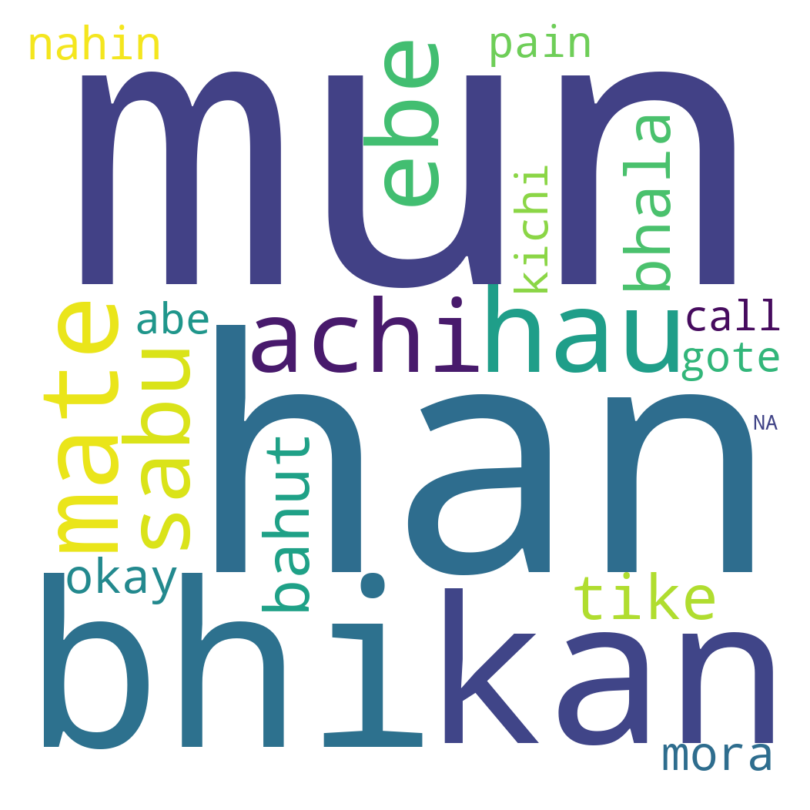

🤣Pupul


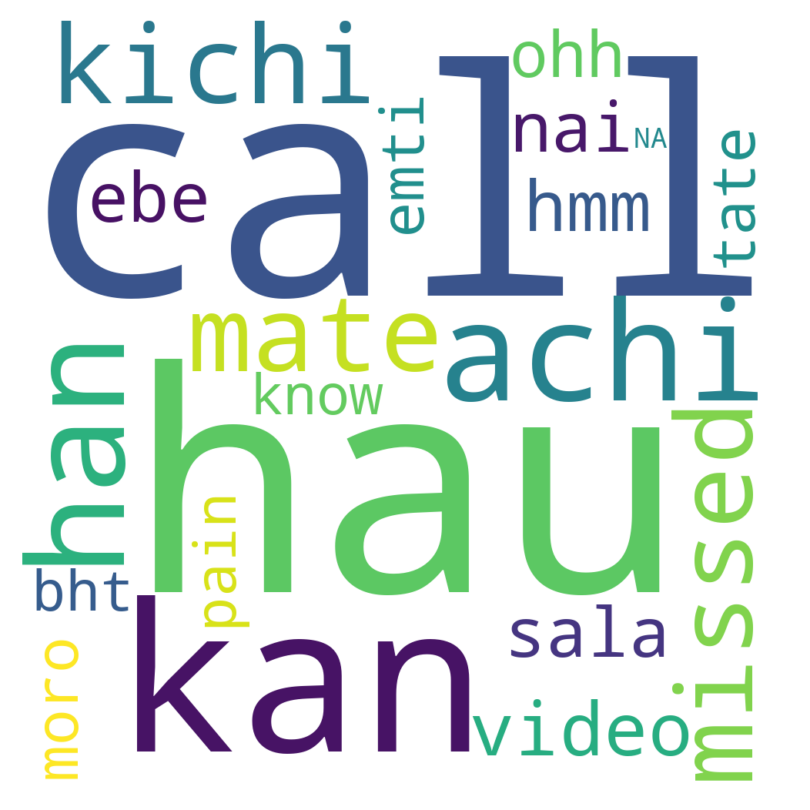

In [22]:
#@title
#Iterate through each name in the dataset and create a list containing all the messages sent by the individual
dstr_grp=''
dlist_grp=[]
for name in df_author_more_info['Author']:
  data1 = df_clean[df_clean['Author']==name]
  dstr = ' '.join(data1['Message'])# create a single string containing all the words from all the messages
  dlist = data1['Message'].to_list()# convert the df column into a list
  dstr_grp=dstr_grp+dstr


  
  #names['avgTime'][names['Name']==name] = data1['Time'].mean().strftime("%I:%M %p")

  NW = []#blank list to store no. of words in a message
  for n in dlist:
    NW.append(len(n.split()))#store number of words in each message
  df_author_more_info['avgWordspermessage'][df_author_more_info['Author']==name] = np.mean(NW)#mean of length of all words
  df_author_more_info['minWordspermessage'][df_author_more_info['Author']==name] = np.min(NW)#min number of words
  df_author_more_info['maxWordspermessage'][df_author_more_info['Author']==name] = np.max(NW)#max number of words
 


  NE = []#blank list to store emojis
  NE = [e for e in dstr if e in emoji.UNICODE_EMOJI]
  dfE = pd.DataFrame({'Emoji':NE})
  EmoFreqdf = pd.DataFrame(dfE.groupby(['Emoji'])['Emoji'].count())
  EmoFreqdf.columns = ['Freq']
  EmoFreqdf = EmoFreqdf.reset_index()
  EmoFreqdf.columns = ['Emoji','Freq']
  df_author_more_info['emovocab'][df_author_more_info['Author']==name] = len(EmoFreqdf)#store total number of unique emojis used
  df_author_more_info['totalemojis'][df_author_more_info['Author']==name] = EmoFreqdf['Freq'].sum()#store total number of emojis sent
  EmoFreqdf = EmoFreqdf.sort_values('Freq',ascending=False)
  df_author_more_info['top5emojis'][df_author_more_info['Author']==name] = ' '.join(EmoFreqdf['Emoji'][0:5])#store top 5 emojis

  #following set of codes are used to clean texts coming from different sources like html etc.
  msgbuffer = dstr.encode('ascii', 'ignore').decode('ascii')
  msgbuffer = re.sub(r'[`!?~@#$%^&*()_+-=<>,.:;]', '', msgbuffer)
  msgbuffer = re.sub(r'[–]', '', msgbuffer)
  msgbuffer = re.sub(r'[\[\]\(\)\{\}]', '', msgbuffer)
  msgbuffer = re.sub(r'[\t\"\'\/\\]', '', msgbuffer)
  lstAllWords = msgbuffer.split()

  #Remove those words which have a length less than or equal to 2
  lstTmpWords=[]
  for Word in lstAllWords:
      if len(Word)>2:
          lstTmpWords.append(Word)
  lstAllWords = lstTmpWords
  del lstTmpWords

  #convert all the words to lower case
  for i in range(0,len(lstAllWords)):
      lstAllWords[i] = (lstAllWords[i]).lower()

  #remove those words which are in stop and emojis
  Words_df = pd.DataFrame({'Words':lstAllWords})
  Words_df = Words_df[-Words_df['Words'].isin(stop)]
  Words_df = Words_df[-Words_df['Words'].isin(emoji.UNICODE_EMOJI.keys())]

  WordsFreqdf = pd.DataFrame(Words_df.groupby(['Words'])['Words'].count())
  WordsFreqdf.columns = ['Freq']
  WordsFreqdf = WordsFreqdf.reset_index()
  WordsFreqdf.columns = ['Word','Freq']
  df_author_more_info['vocab'][df_author_more_info['Author']==name] = len(WordsFreqdf)#total number of unique words
  WordsFreqdf = WordsFreqdf.sort_values('Freq',ascending=False)
  df_author_more_info['top5words'][df_author_more_info['Author']==name] = ' '.join(WordsFreqdf['Word'][0:5])#Top 5 words

  print('\U0001F923'+name)
  d = {'NA':1} #initial dictionary with NA
  for a, x in WordsFreqdf[0:20].values:
      d[a] = x

  #Use generate_word_cloud_from_frequency function  
  wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 25, contour_width=3, contour_color='firebrick').generate_from_frequencies(d)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

  lstLines = sent_tokenize(dstr) #tokenize sentences
  lstLines = [t.lower() for t in lstLines]
  #Remove all the punctuations; 3rd argument in maketrans means it is mapped to None
  lstLines = [t.translate(str.maketrans('','',string.punctuation)) for t in lstLines]
  SenScores = [nltk_sentiment(t) for t in lstLines]
  # create dataframe
  df_temp = pd.DataFrame(lstLines, columns=['Lines'])
  df_temp['Pos']=[t['pos'] for t in SenScores]
  df_temp['Neu']=[t['neu'] for t in SenScores]
  df_temp['Neg']=[t['neg'] for t in SenScores]

  #df['Result']= [getResult(t['pos'],t['neu'],t['neg']) for t in SenScores]
  df_author_more_info['Pos'][df_author_more_info['Author']==name] = df_temp['Pos'].mean()
  df_author_more_info['Neu'][df_author_more_info['Author']==name] = df_temp['Neu'].mean()
  df_author_more_info['Neg'][df_author_more_info['Author']==name] = df_temp['Neg'].mean()  
    


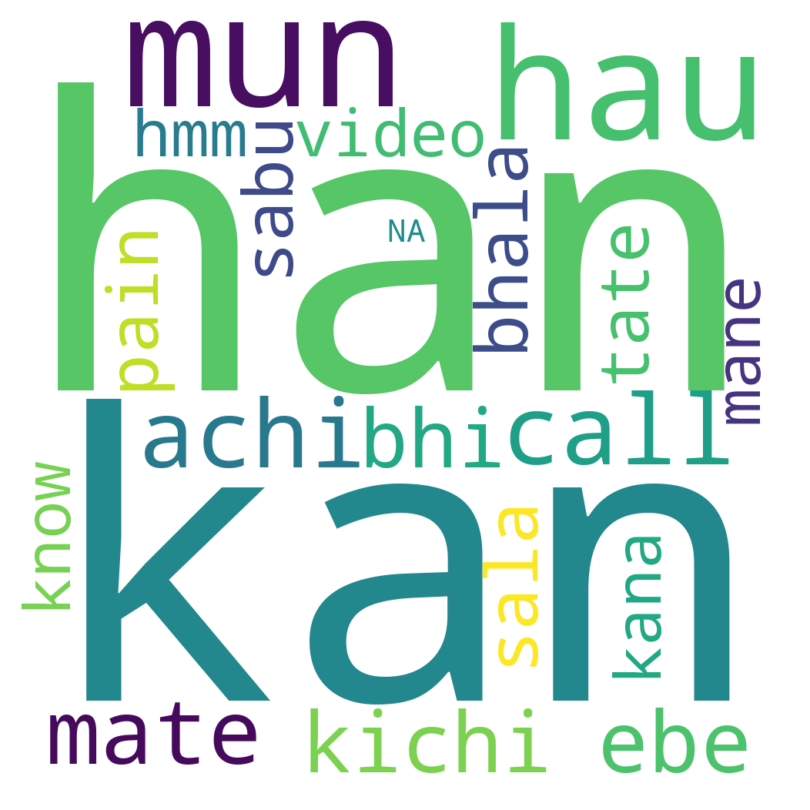

In [23]:
#@title
 
Group['avgWordspermessage']=(Group['Word_count']/Group['Messages_texted']).round(0)#mean of length of all words
Group['minWordspermessage']=df_author_more_info['minWordspermessage'].min()#min number of words
Group['maxWordspermessage']=df_author_more_info['maxWordspermessage'].max()#max number of words




NE = []#blank list to store emojis
NE = [e for e in dstr_grp if e in emoji.UNICODE_EMOJI]
dfE = pd.DataFrame({'Emoji':NE})
EmoFreqdf = pd.DataFrame(dfE.groupby(['Emoji'])['Emoji'].count())
EmoFreqdf.columns = ['Freq']
EmoFreqdf = EmoFreqdf.reset_index()
EmoFreqdf.columns = ['Emoji','Freq']
Group['emovocab'] = len(EmoFreqdf)#store total number of unique emojis used
Group['totalemojis']= EmoFreqdf['Freq'].sum()#store total number of emojis sent
EmoFreqdf = EmoFreqdf.sort_values('Freq',ascending=False)
Group['top10emojis']= ' '.join(EmoFreqdf['Emoji'][0:10])#store top 5 emojis


#following set of codes are used to clean texts coming from different sources like html etc.
msgbuffer = dstr_grp.encode('ascii', 'ignore').decode('ascii')
msgbuffer = re.sub(r'[`!?~@#$%^&*()_+-=<>,.:;]', '', msgbuffer)
msgbuffer = re.sub(r'[–]', '', msgbuffer)
msgbuffer = re.sub(r'[\[\]\(\)\{\}]', '', msgbuffer)
msgbuffer = re.sub(r'[\t\"\'\/\\]', '', msgbuffer)
lstAllWords = msgbuffer.split()

  #Remove those words which have a length less than or equal to 2
lstTmpWords=[]
for Word in lstAllWords:
  if len(Word)>2:
    lstTmpWords.append(Word)
lstAllWords = lstTmpWords
del lstTmpWords

  #convert all the words to lower case
for i in range(0,len(lstAllWords)):
  lstAllWords[i] = (lstAllWords[i]).lower()

  #remove those words which are in stop and emojis
Words_df = pd.DataFrame({'Words':lstAllWords})
Words_df = Words_df[-Words_df['Words'].isin(stop)]
Words_df = Words_df[-Words_df['Words'].isin(emoji.UNICODE_EMOJI.keys())]

WordsFreqdf = pd.DataFrame(Words_df.groupby(['Words'])['Words'].count())
WordsFreqdf.columns = ['Freq']
WordsFreqdf = WordsFreqdf.reset_index()
WordsFreqdf.columns = ['Word','Freq']
Group['vocab'] = len(WordsFreqdf)#total number of unique words
WordsFreqdf = WordsFreqdf.sort_values('Freq',ascending=False)
Group['top5words'] = ' '.join(WordsFreqdf['Word'][0:5])#Top 5 words

d = {'NA':1} #initial dictionary with NA
for a, x in WordsFreqdf[0:20].values:
  d[a] = x

#Use generate_word_cloud_from_frequency function  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 25, contour_width=3, contour_color='firebrick').generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

lstLines = sent_tokenize(dstr_grp) #tokenize sentences
lstLines = [t.lower() for t in lstLines]
#Remove all the punctuations; 3rd argument in maketrans means it is mapped to None
lstLines = [t.translate(str.maketrans('','',string.punctuation)) for t in lstLines]
SenScores = [nltk_sentiment(t) for t in lstLines]
# create dataframe
df_temp = pd.DataFrame(lstLines, columns=['Lines'])
df_temp['Pos']=[t['pos'] for t in SenScores]
df_temp['Neu']=[t['neu'] for t in SenScores]
df_temp['Neg']=[t['neg'] for t in SenScores]

  #df['Result']= [getResult(t['pos'],t['neu'],t['neg']) for t in SenScores]
Group['Pos'] = df_temp['Pos'].mean()
Group['Neu'] = df_temp['Neu'].mean()
Group['Neg'] = df_temp['Neg'].mean()  
    



In [24]:
#@title
#Add additional info
df_author_more_info['Vocab_score']=(100*df_author_more_info['vocab']/df_author_more_info['Word_count']).round()
Group['Vocab_score']=(100*Group['vocab']/Group['Word_count']).round()
df_author_more_info

,Author,Messages_texted,Word_count,avgWordspermessage,minWordspermessage,maxWordspermessage,emovocab,totalemojis,top5emojis,vocab,top5words,Pos,Neu,Neg,Vocab_score
0,Khirod Sahoo,17712,60320,3.403342,1,497,94,2144,😘 😏 😅 🙄 🤣,8907,mun han bhi kan hau,0.103870,0.836772,0.057978,15.0
1,Pupul,22285,71680,3.203590,1,524,108,6613,🏻 😏 ♀ 🙄 😒,8567,call hau kan achi han,0.066104,0.881465,0.048463,12.0


In [25]:
#@title
#Emojis information of individuals
print("\033[1m" + "Total number of unique emojis used and total number of emojis used" + "\033[0m")
df_author_more_info[['Author','emovocab','totalemojis']].sort_values(by='totalemojis',ascending=False)

Total number of unique emojis used and total number of emojis used


,Author,emovocab,totalemojis
1,Pupul,108,6613
0,Khirod Sahoo,94,2144


In [26]:
#@title
#Top emojis used
print("\033[1m" + "Top emojis" + "\033[0m")
df_author_more_info[['Author','top5emojis']].sort_values(by='Author',ascending=False)

Top emojis


,Author,top5emojis
1,Pupul,🏻 😏 ♀ 🙄 😒
0,Khirod Sahoo,😘 😏 😅 🙄 🤣


In [27]:
#@title
#Total unique words used
print("\033[1m" + "Total number of unique words used" + "\033[0m")
df_author_more_info[['Author','vocab','Word_count']].sort_values(by='vocab',ascending=False)

Total number of unique words used


,Author,vocab,Word_count
0,Khirod Sahoo,8907,60320
1,Pupul,8567,71680


In [28]:
#@title
#Percentage of unique words used
print("\033[1m" + "Percentage of unique words used" + "\033[0m")
df_author_more_info[['Author','Vocab_score']].sort_values(by='Vocab_score',ascending=False)

Percentage of unique words used


,Author,Vocab_score
0,Khirod Sahoo,15.0
1,Pupul,12.0


In [29]:
#@title

#Sentiment analysis
print("\033[1m" + "Sentiment analysis of sentences used sorted by Pos" + "\033[0m")
df_author_more_info[['Author','Pos','Neu','Neg']].sort_values(by='Pos',ascending=False)

Sentiment analysis of sentences used sorted by Pos


,Author,Pos,Neu,Neg
0,Khirod Sahoo,0.103870,0.836772,0.057978
1,Pupul,0.066104,0.881465,0.048463


In [30]:
#@title
print("\033[1m" + "Total messages sent in the group" + "\033[0m" )
print(str(Group['Messages_texted'][0])+'\n')
print("\033[1m" + "Total no. of male individuals in the group" + "\033[0m" )
print(str(Group['Males'][0])+'\n')
print("\033[1m" + "Total no. of female individuals in the group" + "\033[0m" )
print(str(Group['Females'][0])+'\n')
print("\033[1m" + "Total no. of Activities in the group" + "\033[0m" )
print(str(Group['Activities'][0])+'\n')
print("(Activities means actions like adding someone or changeing the group dp\n)")
print("\033[1m" + "Total Media shared in the group" + "\033[0m" )
print(str(Group['Media_shared'][0])+'\n')
print("\033[1m" + "Total  messages deleted in the group" + "\033[0m" )
print(str(Group['Total_deleted_Msgs'][0])+'\n')
print("\033[1m" + "Messages sent per day btwn start and end date" + "\033[0m" )
print(str(Group['Frequency'][0])+'\n')
print("\033[1m" + "Messages sent per active day" + "\033[0m" )
print(str(Group['Agressiveness'][0])+'\n')
print("\033[1m" + "Total no. of emojis used in the group" + "\033[0m" )
print(str(Group['totalemojis'][0])+'\n')
print("\033[1m" + "Total no. of unique emojis used in the group" + "\033[0m" )
print(str(Group['emovocab'][0])+'\n')
print("\033[1m" + "Top 10 emojis used in the group" + "\033[0m" )
print(str(EmoFreqdf.set_index('Emoji').head(10))+'\n')
print("\033[1m" + "Total unique words used in the group" + "\033[0m" )
print(str(Group['vocab'][0])+'\n')
print("\033[1m" + "Top 10 words used in the group" + "\033[0m" )
print(str(WordsFreqdf.set_index('Word').head(10))+'\n')
print("\033[1m" + "Sentiment of the messages in the group" + "\033[0m" )
print("Postivity: "+str(Group['Pos'][0]*100)+"%"+'\n')
print("Negativity: "+str(Group['Neg'][0]*100)+"%"+'\n')
print("Neutrality: "+str(Group['Neu'][0]*100)+"%"+'\n')
print("\033[1m" + "Percentage of unique words used in the group" + "\033[0m")
print(str(Group['Vocab_score'][0])+'\n')

Total messages sent in the group
39997

Total no. of male individuals in the group
1

Total no. of female individuals in the group
1

Total no. of Activities in the group
0

(Activities means actions like adding someone or changeing the group dp
)
Total Media shared in the group
1567

Total  messages deleted in the group
23

Messages sent per day btwn start and end date
92.78

Messages sent per active day
95.23

Total no. of emojis used in the group
8757

Total no. of unique emojis used in the group
139

Top 10 emojis used in the group
       Freq
Emoji      
😏       858
😘       608
😅       605
🏻       571
🙄       569
♀       524
😒       359
🤦       331
🙈       328
🤭       302

Total unique words used in the group
13643

Top 10 words used in the group
       Freq
Word       
han     996
kan     959
mun     907
hau     878
call    742
achi    701
mate    632
ebe     568
kichi   548
bhi     506

Sentiment of the messages in the group
Postivity: 7.62413793103449%

Negativity: 5.1029764065

39997

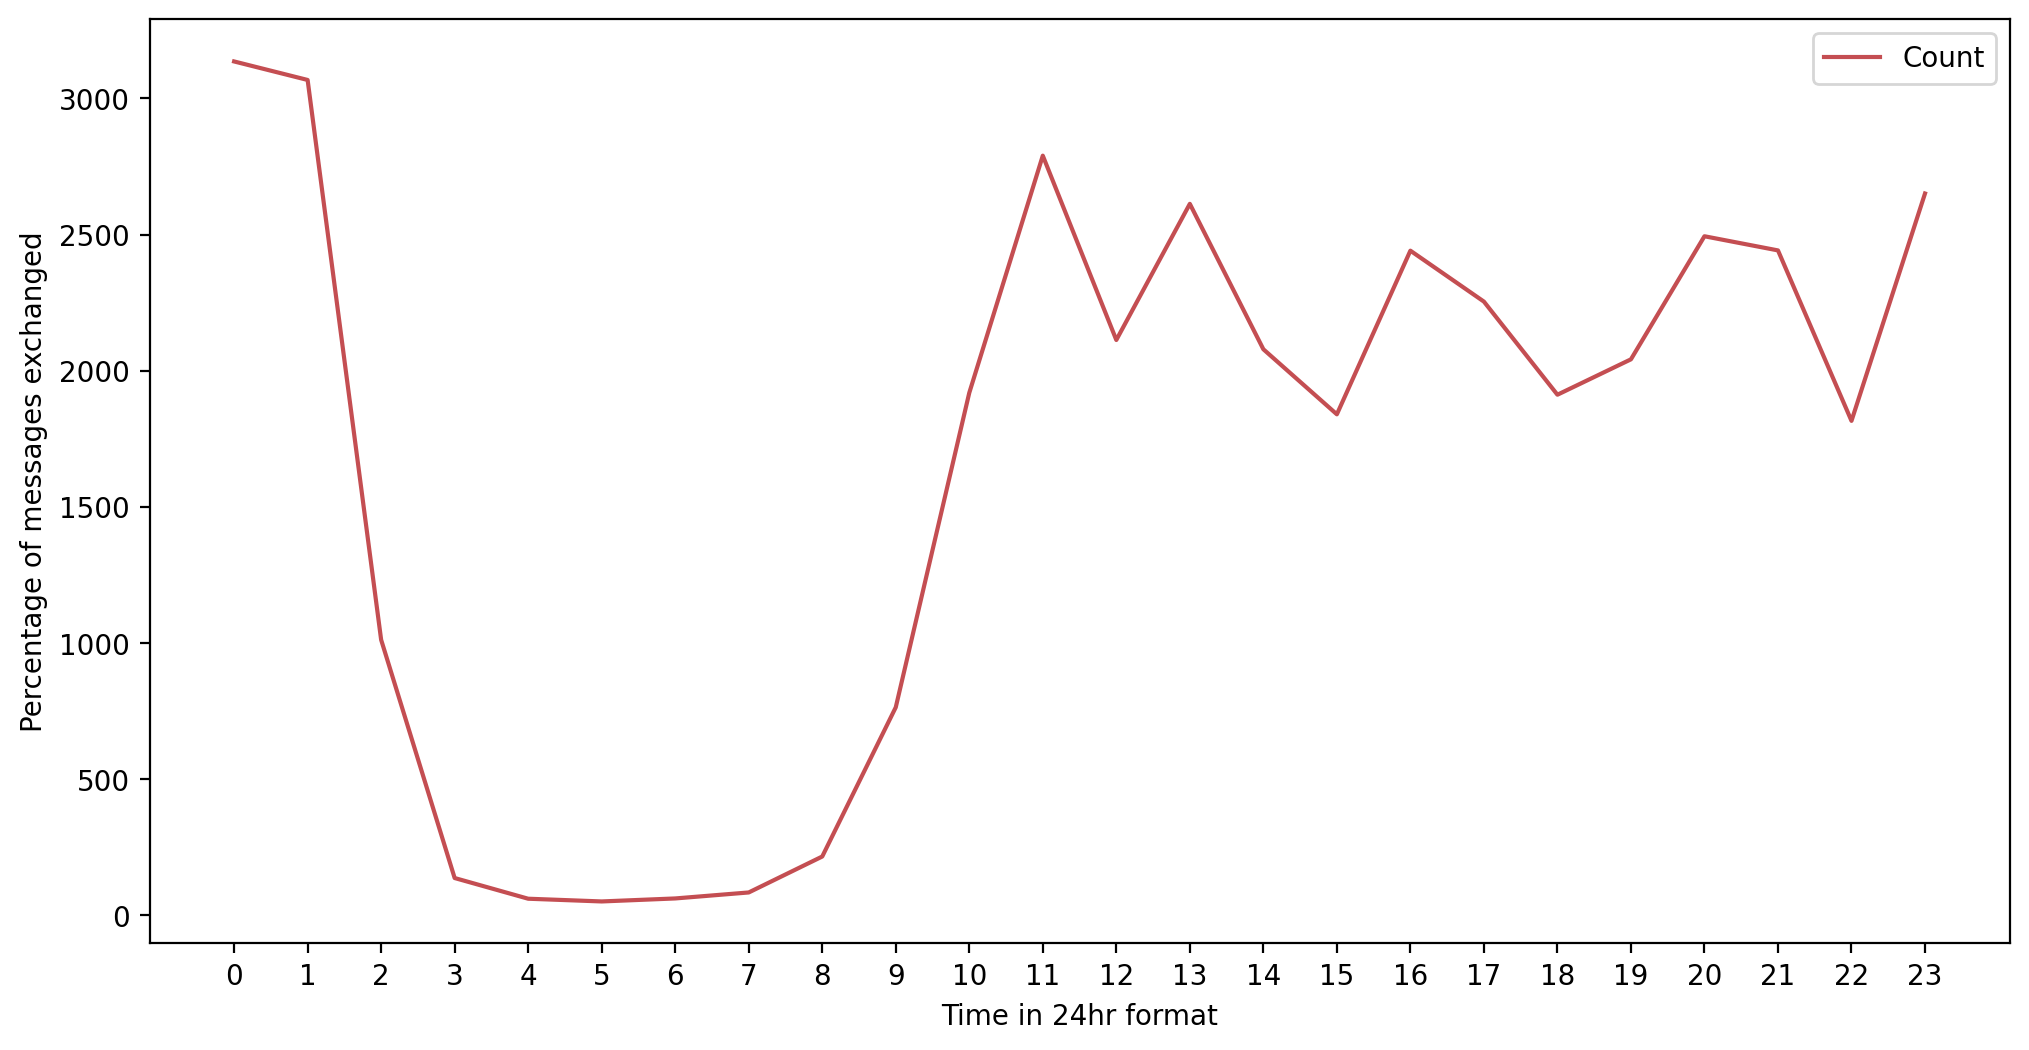

In [32]:
#Group text pattern
Hr_count = df_clean['Hours'].value_counts()

dfHFreqs=pd.DataFrame({'Hours':Hr_count.index,'Count':Hr_count})
dfHFreqs = dfHFreqs.fillna(0)
title='Group Texting pattern'
xlabel='Time in 24hr format'
ylabel='Percentage of messages exchanged'

dfHFreqs['Hours']=dfHFreqs['Hours'].astype(int)
dfHFreqs.sort_values(by='Hours',ascending=True,inplace=True)
plt.figure()
ax=dfHFreqs.iloc[:,1].plot(legend=True,figsize=(12,6),color='r')
ax.set(xlabel=xlabel, ylabel=ylabel);
ax.set_xticks(ticks=np.arange(start=0,stop=24,step=1))
ax.set_xticklabels(labels=np.array(dfHFreqs['Hours']))

Hr_count.sum()

In [0]:
!pip install nbconvert


In [0]:
!pip --version

In [33]:
!jupyter nbconvert --to html /content/WhatsApp_analyser_ver3.ipynb

[NbConvertApp] Converting notebook /content/WhatsApp_analyser_ver3.ipynb to html
[NbConvertApp] Writing 1570101 bytes to /content/WhatsApp_analyser_ver3.html


In [0]:
print(df_clean.head())
df_clean[df_clean['Hours']=='20']